#### 1. Load packages

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle, random

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential,load_model,Model
from keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

#### 2. Load data, transfer to pands dataframes, and review the first 3 rows

In [2]:
audio_emb_file = '/home/drorco/DC_corsound_submission/audio_embeddings.pickle'
face_emb_file = '/home/drorco/DC_corsound_submission/image_embeddings.pickle'

audio_emb = pickle.load(open(audio_emb_file, "rb"))
face_emb = pickle.load(open(face_emb_file, "rb"))

audio_df =  pd.DataFrame.from_dict(audio_emb).T.reset_index()
face_df =  pd.DataFrame.from_dict(face_emb).T.reset_index()


In [3]:
audio_df.head(3)

,index,0,1,2,3,4,5,6,7,8,...,182,183,184,185,186,187,188,189,190,191
0,Ronan_Farrow/aaSZM4e7AU8/00102.wav,33.898537,3.921535,-20.368700,-47.556862,-4.989654,-18.455454,12.782804,19.325085,6.648265,...,-6.505846,13.317440,16.088955,10.481414,-1.055707,3.693741,32.395004,3.947245,-0.548808,-32.880100
1,Ronan_Farrow/iHoOkskbwz8/00141.wav,2.208049,-27.211391,12.965365,21.879303,10.028281,14.146223,-32.257832,-4.648191,16.460787,...,-16.311125,-8.107459,2.558080,-32.009212,-29.041698,20.518143,-1.100664,1.003822,31.168587,13.086949
2,Ronan_Farrow/DTLV2-9nMNI/00034.wav,9.009793,41.082924,-10.212173,-25.880884,15.122940,-4.969586,1.046486,13.861155,9.851394,...,2.750567,10.616673,7.339180,-5.395815,11.826921,-13.325937,23.457645,-6.737992,9.119067,-15.492328


In [4]:
face_df.head(3)

,index,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,Ronan_Farrow/1.jpg,-0.059632,0.064536,-0.008410,-0.055838,0.028547,-0.109469,-0.018306,0.055878,0.032933,...,0.069911,-0.037521,0.045062,0.059087,0.006203,0.057657,-0.045365,0.002749,-0.009480,-0.031032
1,Ronan_Farrow/3.jpg,-0.071796,0.073578,-0.004804,-0.075755,0.030988,-0.097710,-0.006907,0.061086,0.034162,...,0.054289,-0.036864,0.030649,0.051350,0.012039,0.069078,-0.028601,0.009141,-0.008253,-0.027167
2,Ronan_Farrow/6.jpg,-0.058867,0.064723,0.004169,-0.053614,0.030354,-0.132318,-0.013864,0.022884,0.045510,...,0.095136,-0.036495,0.043408,0.076348,0.015769,0.033067,-0.037924,0.010873,0.012708,-0.031592


#### 3. Get the identity (Name) in each modality and generate the mean face embedding for each name
It appears that the Name (ID) appears in the string inside the 'index', just before the first slash. <br> After the slash comes the identifier of the file. <br> Hence I split the index in both modalities before the first slash, and give a regular numbering for the files of each ID.  

In [5]:
audio_df[['s_Name','s_file']] = audio_df['index'].str.split('/', n=1, expand=True)
audio_df = audio_df.sort_values(by=['s_Name','index'])
audio_df['s_audio_fNum'] = audio_df.groupby('s_Name')['index'].rank(method='first').astype('int')
audio_df = audio_df.drop(columns=['index','s_file'])
audio_df= audio_df.set_index(['s_Name','s_audio_fNum']).add_prefix('audio_col_').reset_index()

audio_cols = [col for col in audio_df.columns if 'col_' in col]


In [6]:
face_df[['s_Name','s_file']] = face_df['index'].str.split('/', n=1, expand=True)
face_df = face_df.sort_values(by=['s_Name','index'])
face_df['s_face_fNum'] = face_df.groupby('s_Name')['index'].rank(method='first').astype('int')
face_df = face_df.drop(columns=['index','s_file'])
face_df= face_df.set_index(['s_Name','s_face_fNum']).add_prefix('face_col_').reset_index()

face_cols = [col for col in face_df.columns if 'col_' in col]

#### 4. Create an averaged face embedding for each ID
The model that I will train is about to transform each of the audio embeddings into a face ambeddings.<br>
Since for some of the IDs in the dataset there are more then 1 face embeddings, my goal is to train the model to transform each of the sound embeddings to the average face embedding of the same ID. <br>
For this I need to average the face embedding of each ID.

In [7]:
face_df_grouped = face_df.drop(columns=['s_face_fNum']).groupby(['s_Name']).agg('mean').reset_index()

#### 5. Combine data modalities - all examples of sound with the average face embedding of the same identity.
This creates a unified dataset of both modalities that I will next split to train, validation, test

In [8]:
combined_df  = audio_df.merge(face_df_grouped,on='s_Name',how='inner').dropna()

#### 6. Split the data to train, validation, and test, and shuffle the training dataset
The testset will contain all family names starting with ['C' , 'D', 'E'] <br>
The valset will contain all family names starting with ['A' , 'B']  <br>
The trainset will contain all remaining IDs

In [9]:
print('The number of unique IDs in the entire data: ', combined_df['s_Name'].nunique())

test_grouped_df = combined_df[(combined_df['s_Name'].str.contains('_C'))|(combined_df['s_Name'].str.contains('_D'))|(combined_df['s_Name'].str.contains('_E'))]
print('The number of unique IDs in the test dataset: ', test_grouped_df['s_Name'].nunique())

val_df =combined_df[(combined_df['s_Name'].str.contains('_A'))|(combined_df['s_Name'].str.contains('_B'))]
print('The number of unique IDs in the validation dataset: ', val_df['s_Name'].nunique())

reserved_names_list = test_grouped_df['s_Name'].unique().tolist()+val_df['s_Name'].unique().tolist()
train_df = combined_df[~combined_df['s_Name'].isin(reserved_names_list)]
print('The number of unique IDs in the training dataset: ',train_df['s_Name'].nunique())

train_df = train_df.sample(frac = 1)


The number of unique IDs in the entire data:  2979
The number of unique IDs in the test dataset:  424
The number of unique IDs in the validation dataset:  390
The number of unique IDs in the training dataset:  2176


#### 7. Reserve a similar testset, with the same IDS, only with the original face embeddings (not-averaged) 

In [10]:
ungrouped_face_test_df = face_df[face_df['s_Name'].isin(test_grouped_df['s_Name'].unique().tolist())]

#### 8. Define the Autoencoder model
The model will receive the audio embeddings and produce a predicted face embedding. <br>
The loss is the mean averaged error between the predicted face embedding output and the avereraged face embedding of the same ID. 

In [ ]:

input_len = len(audio_cols)
output_len = len(face_cols)

model_AE_audio_face_1 = Sequential()
model_AE_audio_face_1.add(Dense(input_len, input_shape=(input_len,)))
model_AE_audio_face_1.add(LeakyReLU(alpha=0.1))
model_AE_audio_face_1.add(BatchNormalization())
model_AE_audio_face_1.add(Dense(input_len))
model_AE_audio_face_1.add(LeakyReLU(alpha=0.1))
model_AE_audio_face_1.add(BatchNormalization())
model_AE_audio_face_1.add(Dense(input_len))
model_AE_audio_face_1.add(LeakyReLU(alpha=0.1))
model_AE_audio_face_1.add(BatchNormalization())
model_AE_audio_face_1.add(Dense(input_len))
model_AE_audio_face_1.add(LeakyReLU(alpha=0.1))
model_AE_audio_face_1.add(BatchNormalization())
model_AE_audio_face_1.add(Dense(input_len))
model_AE_audio_face_1.add(LeakyReLU(alpha=0.1))
model_AE_audio_face_1.add(BatchNormalization())
model_AE_audio_face_1.add(Dense(input_len))
model_AE_audio_face_1.add(LeakyReLU(alpha=0.1))
model_AE_audio_face_1.add(BatchNormalization())
model_AE_audio_face_1.add(Dense(input_len))
model_AE_audio_face_1.add(LeakyReLU(alpha=0.1))
model_AE_audio_face_1.add(Dense(128))
model_AE_audio_face_1.add(LeakyReLU(alpha=0.1))
model_AE_audio_face_1.add(Dense(64))
model_AE_audio_face_1.add(LeakyReLU(alpha=0.1))
model_AE_audio_face_1.add(Dense(256))
model_AE_audio_face_1.add(LeakyReLU(alpha=0.1))
model_AE_audio_face_1.add(Dense(output_len))

#### 9. Train the model while saving iteration at the best validation loss  

In [12]:
adam = Adam(learning_rate=0.0001)
model_path = '/home/drorco/DC_corsound_submission/checkpnt1.pkl'
chk_pnt = ModelCheckpoint(model_path, monitor='val_loss',save_best_only=True,mode='auto',verbose=1)
model_AE_audio_face_1.compile(loss='mae',optimizer=adam, metrics=['mae'])
history = model_AE_audio_face_1.fit(train_df[audio_cols],train_df[face_cols] ,epochs=30,callbacks=[chk_pnt],shuffle=True,batch_size=30,validation_data=(val_df[audio_cols],val_df[face_cols] ),verbose=1)


Epoch 1/30
721/726 [============================>.] - ETA: 0s - loss: 0.0382 - mae: 0.0382
Epoch 00001: val_loss improved from inf to 0.03364, saving model to /home/drorco/DC_corsound_submission/checkpnt1.pkl


2023-08-05 19:51:32.739449: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/drorco/DC_corsound_submission/checkpnt1.pkl/assets
726/726 [==============================] - 8s 8ms/step - loss: 0.0382 - mae: 0.0382 - val_loss: 0.0336 - val_mae: 0.0336
Epoch 2/30
725/726 [============================>.] - ETA: 0s - loss: 0.0337 - mae: 0.0337
Epoch 00002: val_loss improved from 0.03364 to 0.03355, saving model to /home/drorco/DC_corsound_submission/checkpnt1.pkl
INFO:tensorflow:Assets written to: /home/drorco/DC_corsound_submission/checkpnt1.pkl/assets
726/726 [==============================] - 6s 8ms/step - loss: 0.0337 - mae: 0.0337 - val_loss: 0.0336 - val_mae: 0.0336
Epoch 3/30
717/726 [============================>.] - ETA: 0s - loss: 0.0337 - mae: 0.0337
Epoch 00003: val_loss improved from 0.03355 to 0.03355, saving model to /home/drorco/DC_corsound_submission/checkpnt1.pkl
INFO:tensorflow:Assets written to: /home/drorco/DC_corsound_submission/checkpnt1.pkl/assets
726/726 [==============================] - 7s 9ms/step -

#### 10. Review the train and validation loss throughout the training process

(0.03, 0.035)

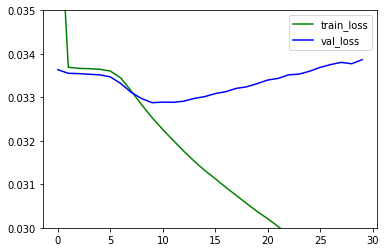

In [13]:
plt.figure()
plt.plot(history.history['loss'],color='g',label='train_loss')
plt.plot(history.history['val_loss'],color='b',label='val_loss')
plt.legend(loc='upper right')
plt.ylim(0.03,0.035)

#### 11. load the best model based on the validation loss

In [14]:
loaded_model = load_model(model_path)

#### 12. Create a predicted face embedding for each of the audio embedding in the test dataset

In [15]:
test_audio = test_grouped_df[['s_Name','s_audio_fNum']+audio_cols]

face_cols_preds = [col+'_pred' for col in face_cols]

test_audio[face_cols_preds] = loaded_model.predict(test_audio[audio_cols])

#### 13. Evaluate the identification accuracy
Here for each of the PREDICTED face embeddings (Anchor) is tested against a random positive and negative Actual face embedding samples. <br> A positive sample - one of the face embeddings of the same ID as the original audio embedding upon which the prediction was made. <br> A negative sample - one of the face embeddings of a different ID. <br> If it is closer to the positive sample it is considered as Correct identification . <br> If it is closer to the negative sample it is considered as False identification. <br> The accuracy is the percentage of correct identifications out of the entire test dataset. <br>
For the sake of time, I choose not to generate all the possible combinations of audio-inputs, positive-face-embeddings, and negative-face embeddings as in the original identification accuracy metric. Instead, I generated predicted face embeddings from all audio-inputs, and compared them with randomly selected samples of positive and negative face embeddings as approximation of the identification accuracy.  

In [16]:
name_list = test_audio['s_Name'].unique().tolist()
l=[]

for name in name_list:
    if name in (ungrouped_face_test_df['s_Name'].unique().tolist()):
        
        rndom_l = [rnd_name for rnd_name in name_list if rnd_name!=name]
        rndom = random.choice(rndom_l)
        
        positive = ungrouped_face_test_df[(ungrouped_face_test_df['s_Name']==name)]
        negative = ungrouped_face_test_df[(ungrouped_face_test_df['s_Name']==rndom)]

        anchor = test_audio[test_audio['s_Name']==name].sort_values(by=['s_Name','s_audio_fNum'])
        
        if ((positive.shape[0]>0) and (anchor.shape[0]>0)):

            for audio_fNum in anchor['s_audio_fNum'].unique().tolist():
                
                curr_pair = positive.sample().append(negative.sample())
                            
                knn = KNeighborsClassifier(n_neighbors=1)
                knn.fit(curr_pair[face_cols], curr_pair['s_Name'])               
                
                pred_name = knn.predict(anchor[anchor['s_audio_fNum']==audio_fNum][face_cols_preds])
                
                l.append(int(pred_name==anchor[anchor['s_audio_fNum']==audio_fNum]['s_Name']))
                
print('The Accuracy is: ', round(sum(l)/len(l),4)*100, '%')              

The Accuracy is:  76.77000000000001 %


#### Overall, the achieved accuracy was in the expected boundaries (75%-80%)